### Assignment 1

- Data Set Choose: Reviews of Musical Instrument
- The following data Musical Instrument is from http://jmcauley.ucsd.edu/data/amazon/

In [1]:
# Data Loading
import pandas as pd
import numpy as np
import gzip
import re
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore') 

#波特词干法
neg_stw = ["never","nothing","nowhere","noone",
           "none","not","haven't","hasn't","hasnt",
           "hadn't","hadnt","can't","cant","couldn't",
           "couldnt","shouldn't","shouldnt","won't",
           "wont","wouldn't","wouldnt","don't","dont",
           "doesn't","doesnt","didn't","didnt","isnt",
           "isn't","aren't","arent","aint",
           "ain't","hardly","seldom"]
stpwrds_wo_neg = [x for x in stopwords.words('english') if x not in neg_stw]
stpwrds = [x for x in stopwords.words('english')]

stemmer = PorterStemmer()

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Musical_Instruments_5.json.gz')
# print(len(df.overall))
# print(df.reviewText)


#### Classification Method 1: 
- Like binary classification, the approach can be extended to multiclass classification

In [2]:
# Data Preprocessing
# part of the code inspired by : https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/Text%20Classification%20With%20Machine%20Learning,SpaCy,Sklearn(Sentiment%20Analysis)/Text%20Classification%20&%20Sentiment%20Analysis%20with%20SpaCy,Sklearn.ipynb

def scorePreprocessor(score):
    # 1  -> positive 
    # -1 -> negative
    # 0  -> neutral 
    res = []
    for i in range(len(score)):
        if score[i] >= 3.0:
            res.append(1)
        else:
            res.append(0)
    return res
    
def handleNegation(review):
    length = len(review)
    i = 0
    negation_String = 'NOT_'
    for i in range(len(review)):
        if review[i] in ["not", "n't", "not"] and i < len(review) -1 :
            # adding negation String
            i = i + 1
            while review[i] not in punctuations and i < len(review) -1:
                review[i] = negation_String + review[i]
                i = i + 1
    return review

#https://www.kaggle.com/chewzy/benchmark-exercise-using-naive-bayes-classifier
def handleNegation1(text):
    
    """
    Input is string (e.g. I am not happy.)
    Output is string with neg tags (e.g. I am not NOT_happy.)
    """
    # \b匹配边界 即单词的位置 \w匹配的是单词的范围 \s 匹配空格 +前面的匹配1次到多次
    
    transformed = re.sub(r"\b(?:never|nothing|nowhere|noone|none|not|haven't|hasn't|hasnt|hadn't|hadnt|can't|cant|couldn't|couldnt|shouldn't|shouldnt|won't|wont|wouldn't|wouldnt|don't|dont|doesn't|doesnt|didn't|didnt|isnt|isn't|aren't|arent|aint|ain't|hardly|seldom)\b[\w\s]+[^\w\s]", lambda match: re.sub(r'(\s+)(\w+)', r'\1NOT_\2', match.group(0)), text, flags=re.IGNORECASE)
    return(transformed)
       

def preprocessing_baseline(review):
    '''
    Input is list of raw sentences.
    Output is sentences without punctuations.
    '''
    
    result_sentence = []
    
    for sub_review in review:
        lowcase = [word.lower() for word in sub_review.split()]
        remove_punc = [re.sub('[^a-zA-Z_]+','',t) for t in lowcase]
        result_sentence.append(remove_punc)
    
    return result_sentence

def preprocessing_neg_tag(review):
    """
    
    """
    
    result_review = []
    
    for sent in review:
        print(sent)
        print()
        
        stemmed = [stemmer.stem(word).lower() 
                   if word.lower() not in neg_stw and word.lower() not in stpwrds_wo_neg 
                   else word.lower() 
                   for word in sent.split()]
        
        stemmed1 = [stemmer.stem(word).lower() for word in sent.split()]
        
        processed = [t for t in stemmed if t not in stpwrds_wo_neg]

        neg_tagged = handleNegation1(' '.join(processed))

        remove_punc = [re.sub('[^a-zA-Z_]+','',t) for t in neg_tagged.split() if t not in neg_stw]
        
        
        morethan3 = [t for t in remove_punc if len(t) > 3]
        
        result_review.append(' '.join(morethan3))
        
        return result_review


def get_uni_bi_tri_grams(list_of_reviews):
    
    """
    Input is list of reviews.
    Outputs are:
    1. Unigrams tokens
    2. Unigrams + Bigrams tokens
    3. Unigrams + Bigrams + Trigram tokens
    """
    
    uni_tokens = [s.split() for s in list_of_reviews]
    bi_tokens = [[' '.join([x,y]) for x,y in ngrams(s.split(),2)] for s in list_of_reviews]
    tri_tokens = [[' '.join([x,y,z]) for x,y,z in ngrams(s.split(),3)] for s in list_of_reviews]

    uni_bi_tokens = [x + uni_tokens[i] for i, x in enumerate(bi_tokens)]
    uni_bi_tri_tokens = [x + uni_tokens[i] + bi_tokens[i] for i, x in enumerate(tri_tokens)]

    return uni_tokens, uni_bi_tokens, uni_bi_tri_tokens


In [3]:
# To allow TFIDF Vectorizer to take in tokenized texts directly

def dummy(doc):
    
    """
    Dummy function to allow TfidVectorizer to take in tokenized texts directly
    """
    
    return doc

#### Traning the sentiment analyser
- First Method, SVM and Naive Bayes Classifier
- Remember : Use Pipeline

In [4]:
# def N_gram(result):
#     # Use the zip function to help us generate n-grams
#     # Concatentate the tokens into ngrams and return
#     ngrams = zip(*[result[i:] for i in range(n)])
#     return [" ".join(ngram) for ngram in ngrams]
    

def stupidBackTosetence(result):
    new_result = []
    for i in range(len(result)):
        sentence = result[i][0]
        for j in range(1, len(result[i])):
            sentence = sentence + " " + result[i][j]
        new_result.append(sentence)
    return new_result


def vectorizeAndNgram(result):
    # verctorize and get feature using bi-gram
    vectorizer = TfidfVectorizer(
                stop_words='english',
                analyzer='word',
                ngram_range=(2, 2),
                max_features=30000)

    # fit_transform on to get the features
    feature = vectorizer.fit_transform(result)
    return feature

def vectorizeNgramBayesPipe():
    text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

    tuned_parameters = {
        'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__alpha': [1, 1e-1, 1e-2]
    }
    return text_clf, tuned_parameters
    

# splitting data to 80% training_set 10% test_set and 10 %dev_set
def dataSplit(X_all, y_all):
    training_size = np.int(X_all.shape[0] * 0.8)
    print(training_size)
    test_size = np.int(X_all.shape[0] * 0.1)
    X_train = X_all[0:training_size]
    X_test = X_all[training_size :training_size + test_size]
    X_dev = X_all[training_size + test_size:]
    
    y_train = y_all[0:training_size]
    y_test = y_all[training_size :training_size + test_size]
    y_dev = y_all[training_size + test_size:]
                                                   
    #print(np.shape(y_dev))                                            
    return X_train, y_train, X_test, y_test, X_dev, y_dev


# scoreTarget = scorePreprocessor(df.overall[0:500])
# review_norm = textNormalization(df.reviewText[0:500])
# review = stupidBackTosetence(review_norm)
# review_processed = vectorizeAndNgram(review)
#X_train, y_train, X_test, y_test, X_dev, y_dev = dataSplit(review_processed, scoreTarget)



# print(np.shape(X_train))
# print(np.shape(X_test))
# print(np.shape(X_dev))
#print(X_train)

In [5]:
def build_models(X_train, y_train, X_test, y_test, feature_range):
    
    model_list = []
    
    # 只取前500个feature
    for features in range(feature_range[0],feature_range[1],500):
        
        tfid = TfidfVectorizer(max_features=features,analyzer=dummy,preprocessor=dummy)
        
        train_set = tfid.fit_transform(x_train)
        test_set = tfid.transform(x_test)
        
        mnb = MultinomialNB()
        mnb.fit(train_set,y_train)
        
        r = {}
        r['features'] = features
        r['train_acc'], r['test_acc'], r['train_f1'], r['test_f1'], r['tr_cf'] , r['te_cf'], _, _ = get_train_test_score(mnb,
                                                                                                                         train_set, 
                                                                                                                         test_set, 
                                                                                                                         y_train, 
                                                                                                                         y_test)
        model_list.append(r)
    
    return model_list

def get_train_test_score(model, x_train, x_test, y_train, y_test):
    
    """
    Function to get train and test score
    """
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_acc = accuracy_score(y_train,y_train_pred)
    test_acc = accuracy_score(y_test,y_test_pred)
    
    train_f1 = f1_score(y_train,y_train_pred,average='weighted')
    test_f1 = f1_score(y_test,y_test_pred,average='weighted')
    
    train_cf = confusion_matrix(y_train,y_train_pred)
    test_cf = confusion_matrix(y_test,y_test_pred)
    
    train_acc, test_acc, train_f1, test_f1 = [round(x*100,1) for x in [train_acc, test_acc, train_f1, test_f1]]
    
    return train_acc, test_acc, train_f1, test_f1, train_cf, test_cf, y_train_pred, y_test_pred


In [6]:
def print_classification_results(description, train_acc, test_acc, train_f1, test_f1, train_cf, test_cf):
    
    """
    Plot the classification results
    """
    
    print(description)

    
    plt.subplot(1,4,1)
    plt.bar(['Accuracy','F1-Score'], [train_acc,train_f1] ,color=['blue','orange'])
    plt.ylim(55,100)
    if train_acc <= 90:
        plt.annotate(str(train_acc) + '%', (-0.07, train_acc + 1))
        plt.annotate(str(train_f1) + '%', (0.93, train_f1 + 1))

    else:
        plt.annotate(str(train_acc) + '%', (-0.07, train_acc - 3))
        plt.annotate(str(train_f1) + '%', (0.93, train_f1 - 3))
        
    plt.title('Training Score')

    plt.subplot(1,4,2)
    plt.bar(['Accuracy','F1-Score'], [test_acc,test_f1] ,color=['blue','orange'])
    plt.ylim(55,100)
    
    if test_acc <= 90:
        plt.annotate(str(test_acc) + '%', (-0.07, test_acc + 1))
        plt.annotate(str(test_f1) + '%', (0.93, test_f1 + 1))

    else:
        plt.annotate(str(test_acc) + '%', (-0.07, test_acc - 3))
        plt.annotate(str(test_f1) + '%', (0.93, test_f1 - 3))

        
        
    plt.title('Testing Score')

    plt.subplot(1,4,3)
    plot_confusion_matrix(train_cf,classes=['negative','positive'],title='Confusion Matrix (Training)')

    plt.subplot(1,4,4)
    plot_confusion_matrix(test_cf,classes=['negative','positive'],title='Confusion Matrix (Testing)')

    plt.show()
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Obtained from sklearn documentations.
    
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plot_pp_best_models(pp_types, pp_desc):
    
    pp_acc, pp_f1 = [], []
    
    pp_labels = list(pp_desc.values())
    
    for pp in pp_types:
        
        best_acc = max(x['test_acc'] for x in models[pp])
        best_f1 = max(x['test_f1'] for x in models[pp])
        
        pp_acc.append(best_acc)
        pp_f1.append(best_f1)
        
    
    
    plt.plot(pp_labels,pp_acc,label='test_acc',marker='o',markersize =10)
    plt.plot(pp_labels,pp_f1,label='test_f1',marker='o',markersize=10, alpha=0.8)
    plt.ylabel('Percentage (%)',fontsize=15)
    plt.xlabel('Preprocessing Method',fontsize=15)

    plt.ylim(min(pp_f1) - 1, max(pp_f1) + 1)
    plt.xticks(fontsize=8)
    
    for index, x in enumerate(pp_types):
        plt.annotate(x,(index - 0.3,min(pp_f1)-0.88),fontsize=20,bbox=dict(boxstyle="round", fc="w"))
    
    plt.grid(True,which='both')
    plt.legend()
    plt.title('Pre-processing Benchmark Results (Multinomial Naive Bayes)\n',fontsize='15')
    plt.show()

# Plot acc and f1 on y, features on x
def plot_acc_f1(pp,feature_range):
        
    tr_acc =[x['train_acc'] for x in models[pp]]
    tr_f1 =[x['train_f1'] for x in models[pp]]
    tr_fea = [x['features'] for x in models[pp]]
    
    te_acc =[x['test_acc'] for x in models[pp]]
    te_f1 =[x['test_f1'] for x in models[pp]]
    te_fea = [x['features'] for x in models[pp]]

    for x in models[pp]:
        if x['test_acc'] == max(te_acc):
            best_model = x
            break
        
    print('===============================================================================================================================\n')
    print('Pre-processing Method\t\t: {}'.format(pp))
    print('Pre-processing Details\t\t: {}'.format(str(pp_desc[pp].replace('\n',' | '))))
    print('Best Model Training Accuracy\t: {} %'.format(best_model['train_acc']))
    print('Best Model Training F1-Score\t: {} %'.format(best_model['train_f1']))
    print('Best Model Testing Accuracy\t: {} %'.format(best_model['test_acc']))
    print('Best Model Testing F1-Score\t: {} %'.format(best_model['test_f1']))
    print('Best Model No. of Features\t: {}'.format(best_model['features']))

    plt.subplot(1,4,1)
    plot_confusion_matrix(best_model['tr_cf'],
                          classes=['negative','positive'],
                          title='Confusion Matrix \n(Best Model, Train Set)\n')
    
    plt.subplot(1,4,2)
    plot_confusion_matrix(best_model['te_cf'],
                          classes=['negative','positive'],
                          title='Confusion Matrix \n(Best Model, Test Set)\n')
    
    plt.subplot(1,4,3)
    plt.plot(tr_fea,tr_acc,label='train_acc')
    plt.plot(tr_fea,tr_f1,label='train_f1')
    plt.ylabel('Percentage (%)')
    plt.xlim(feature_range[0],feature_range[1])
    plt.xlabel('Number of Features')
    plt.grid(True,which='both')
    plt.legend()
    plt.title('Train Set Models Results\n')
    
    plt.subplot(1,4,4)
    plt.plot(te_fea,te_acc,label='test_acc')
    plt.plot(te_fea,te_f1,label='test_f1')
    plt.ylabel('Percentage (%)')
    plt.xlim(feature_range[0],feature_range[1])
    plt.xlabel('Number of Features')
    plt.grid(True,which='both')
    plt.legend()
    plt.title('Test Set Models Results\n')
    

    

    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.reviewText[0:100000],
                                                    scorePreprocessor(df.overall[0:100000]),
                                                    stratify=scorePreprocessor(df.overall[0:100000]),
                                                    test_size=0.3,
                                                    random_state=20)

print(len(x_train),len(x_train),len(x_test),len(y_test))


7182 7182 3079 3079


In [9]:
pp_types = ['BASE','NEG1','NEG2','NEG3']

pp_desc = {  'BASE': 'Baseline',
             'NEG1': '1-gram\nneg tag\nsw, punc removal\nstemming',
             'NEG2': '1,2-grams\nneg tag\nsw, punc removal\nstemming',
             'NEG3': '1,2,3-grams\nneg tag\nsw, punc removal\nstemming',}

models = dict((pp,[]) for pp in pp_types)

In [10]:
x_train_b = preprocessing_baseline(x_train)
x_train_n1, x_train_n2, x_train_n3 = get_uni_bi_tri_grams(preprocessing_neg_tag(x_train))

x_test_b = preprocessing_baseline(x_test)
x_test_n1, x_test_n2, x_test_n3 = get_uni_bi_tri_grams(preprocessing_neg_tag(x_test))

I wanted to try the Clayton Beehold picks to see if the hole would help me grip the pick better so that it doesn't rotate in my hand.The .80 pick is a little too heavy for my style of playing but the hole is a neat idea and did seem to help a bit, but I gave up on the pick pretty quickly due to the stiffness.

The Fender slick string cleaner works great when it is brand new. The great part about it is the design. The fact that it is wide enough to run along all six strings is a definite plus. The things I don't like about it is the top does not close tight enough and can come off during any kind of travel. Once the top is off or just not closed properly, the pad dries out and then it is useless. Also, the little cloth that comes with it is almost impossible to fit back inside the container once you have opened it. As stated it was really good at cleaning and was easy to use but I was only able to use it once because the top came off and it dried out. Unfortunately because of that I wou

In [11]:
feature_range = (15000,45000)

models['BASE'] = build_models(x_train_b,y_train,x_test_b,y_test,feature_range)
models['NEG1'] = build_models(x_train_n1,y_train,x_test_n1,y_test,feature_range)
models['NEG2'] = build_models(x_train_n2,y_train,x_test_n2,y_test,feature_range)
models['NEG3'] = build_models(x_train_n3,y_train,x_test_n3,y_test,feature_range)


Pre-processing Method		: BASE
Pre-processing Details		: Baseline
Best Model Training Accuracy	: 95.4 %
Best Model Training F1-Score	: 93.2 %
Best Model Testing Accuracy	: 95.5 %
Best Model Testing F1-Score	: 93.2 %
Best Model No. of Features	: 15000


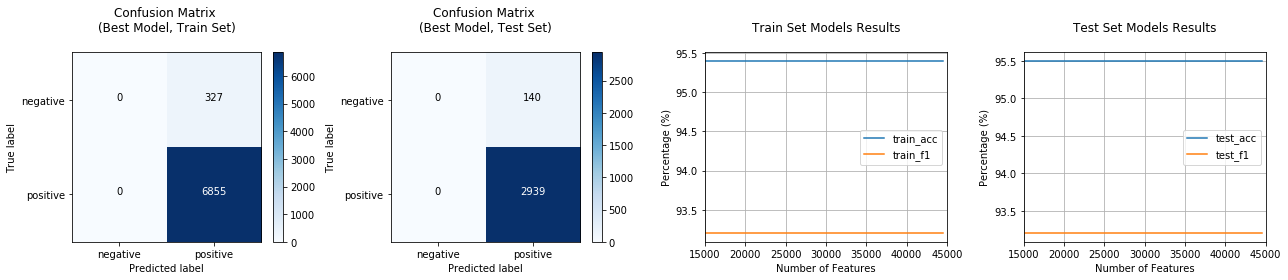


Pre-processing Method		: NEG1
Pre-processing Details		: 1-gram | neg tag | sw, punc removal | stemming
Best Model Training Accuracy	: 95.4 %
Best Model Training F1-Score	: 93.2 %
Best Model Testing Accuracy	: 95.5 %
Best Model Testing F1-Score	: 93.2 %
Best Model No. of Features	: 15000


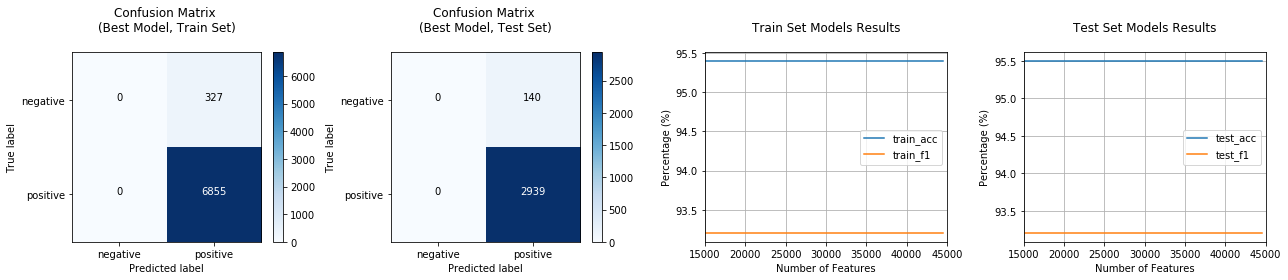


Pre-processing Method		: NEG2
Pre-processing Details		: 1,2-grams | neg tag | sw, punc removal | stemming
Best Model Training Accuracy	: 95.4 %
Best Model Training F1-Score	: 93.2 %
Best Model Testing Accuracy	: 95.5 %
Best Model Testing F1-Score	: 93.2 %
Best Model No. of Features	: 15000


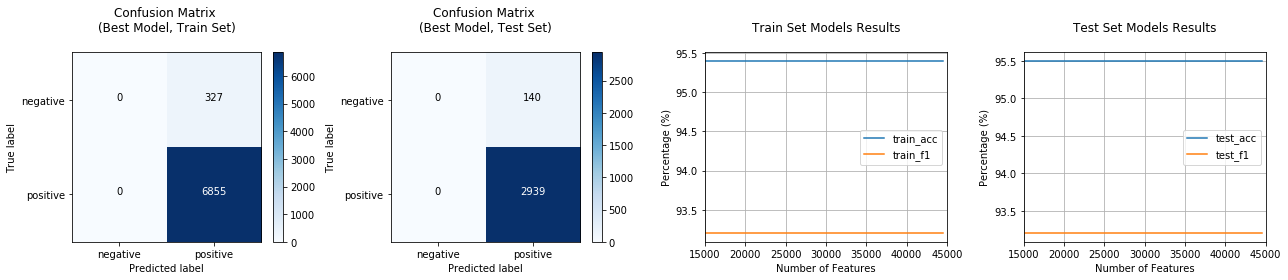


Pre-processing Method		: NEG3
Pre-processing Details		: 1,2,3-grams | neg tag | sw, punc removal | stemming
Best Model Training Accuracy	: 95.4 %
Best Model Training F1-Score	: 93.2 %
Best Model Testing Accuracy	: 95.5 %
Best Model Testing F1-Score	: 93.2 %
Best Model No. of Features	: 15000


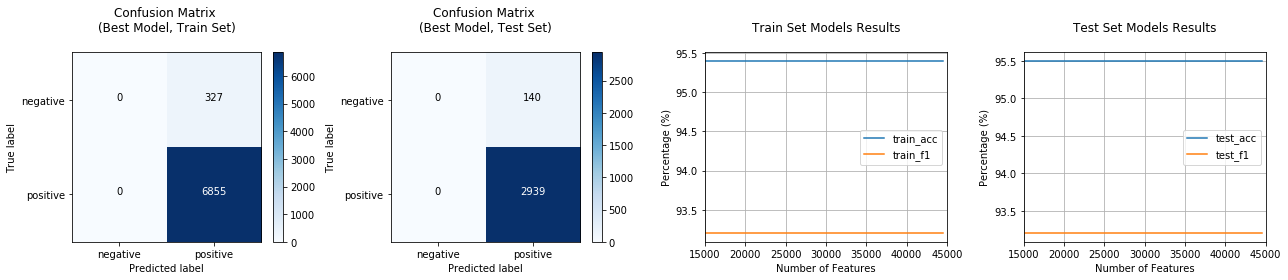

In [12]:
plt.rcParams['figure.figsize'] = [18,4]

for pp in pp_types:
    plot_acc_f1(pp,feature_range)